## Finding an estimate for stratification on the downstream side of the canyon

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns
import xarray as xr

In [2]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('talk')

# Set necessary grid variables and grid file
grid = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc')
rc = grid.RC


In [3]:
# Create an empty class to save information of every run

class run:
    pass

In [4]:
def linear_regression(x, y, prob):
    """
    Return the linear regression parameters and their <prob> confidence intervals.
    ex:
    >>> linear_regression([.1,.2,.3],[10,11,11.5],0.95)
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    xy = x * y
    xx = x * x

    # estimates

    b1 = (xy.mean() - x.mean() * y.mean()) / (xx.mean() - x.mean()**2)
    b0 = y.mean() - b1 * x.mean()
    s2 = 1./n * sum([(y[i] - b0 - b1 * x[i])**2 for i in range(n)])
    print ('b0 = ',b0)
    print ('b1 = ',b1)
    print ('s2 = ',s2)
    
    #confidence intervals
    
    alpha = 1 - prob
    c1 = scipy.stats.chi2.ppf(alpha/2.,n-2)
    c2 = scipy.stats.chi2.ppf(1-alpha/2.,n-2)
    print ('the confidence interval of s2 is: ',[n*s2/c2,n*s2/c1])
    
    c = -1 * scipy.stats.t.ppf(alpha/2.,n-2)
    bb1 = c * (s2 / ((n-2) * (xx.mean() - (x.mean())**2)))**.5
    print ('the confidence interval of b1 is: ',[b1-bb1,b1+bb1])
    
    bb0 = c * ((s2 / (n-2)) * (1 + (x.mean())**2 / (xx.mean() - (x.mean())**2)))**.5
    print ('the confidence interval of b0 is: ',[b0-bb0,b0+bb0])
    return ([n*s2/c2,n*s2/c1],[b1-bb1,b1+bb1],[b0-bb0,b0+bb0])

In [5]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [6]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [7]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
Hh = 97.5 # 

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    retun(f*L/(N))
    
def Z(U=0.36,L=6400.0,N=5.5E-3,R=5000.0):
    '''Depth of upwelling as scaled in Allen and Hickey 2010'''
    return((1.4*U*(L**(1/2)))/(Nos*(R**(1/2))))

def Ro(U=0.36,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.36,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [8]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N_tt06','N_tt08','N_tt10','N_tt12']
key0 = 'N_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    maxd3 = max(df_anom[keys[0]][26:])   
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    

### N proportional to isopycnal tilting:  N\No=Z/Hs

I know N has to be proportional to f, U (if f or U increase, upwelling is more intense and thus isopycnals tilt more) and No (if I already have a more stratified water column than some case then also the stratification within the canyon will be larger than that base case).

N/No represents the relative increase of stratification from the initial value after the upwelling adjustment has occured. It makes sense to think that this relation is proportional to the tilting of isopycnals within the canyon, given by $Z$, where $Z$ is the depth of upwelling, non-dimentionalized by Hs, the depth of the shelf break. This ight not be the right scale for this but for now and since I am not changing the canyon, I will keep this.

$$\frac{N}{N_0}=\beta \frac{Z}{H_s}$$

where $Z = \frac{{fu\mathcal{F}L}^{1/2}}{N_0}$, $\mathcal{F}$ is $Ro/(1+Ro/0.9)$, $Ro$ is a Rossy number with $\mathcal{R}$ as a length scale (Howatt and Allen (2013) say it should be $Wsb$). This leaves

$$\frac{N}{N_0}=\frac{\beta}{H_s N_0} ({fu\mathcal{F}L})^{1/2}$$

So N is independent No.




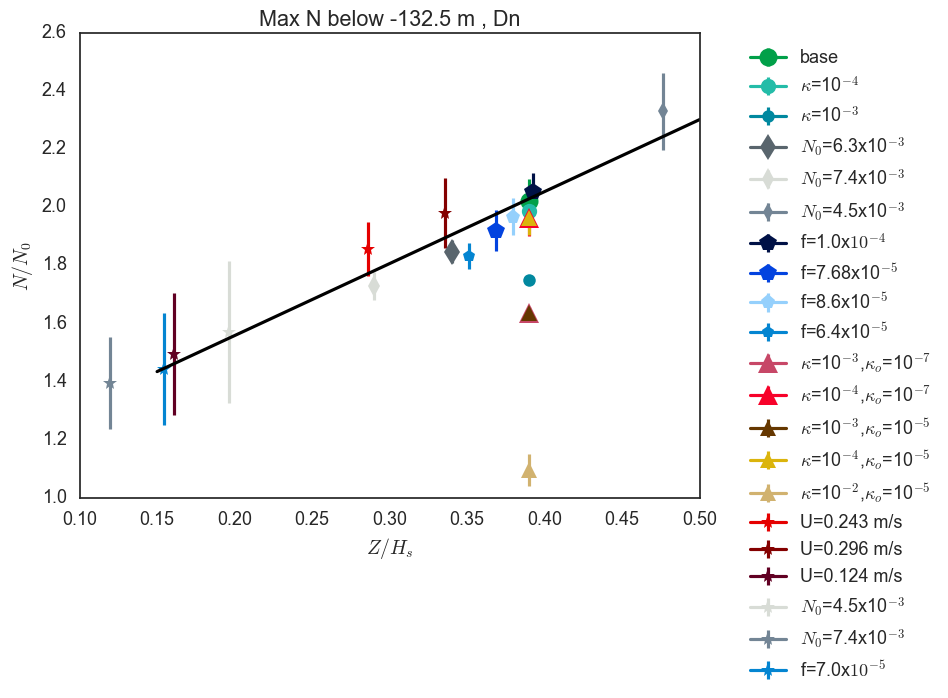

In [9]:
# Let's see it if works


stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.errorbar(((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/(Hs*rec.N),rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    ax.set_title('Max N below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$N/N_0$')
    ax.set_xlabel('$Z/H_s$')

    ax.legend(bbox_to_anchor=(1.4,1))
#ax.set_xscale('log')    


# Linear fit
records_NoKv = [records[0],records[3],records[4],records[5],records[6],records[7],records[8],records[9],records[15],
                records[16],records[17]]

maxN_array = np.array([rec.maxN/rec.N for rec in records_NoKv])
tilt_array = np.array([((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/(Hs*rec.N) for rec in records_NoKv])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tilt_array,maxN_array)

x_fit = np.linspace(0.15, 0.5, 50)

plt2 = ax.plot(x_fit,slope*x_fit+intercept,'-k')

plt.show()



In [10]:
print('slope %f' %slope)
print('intercept %f' %intercept)
print('r_value %f' %(r_value**2))
print('p_value %f' %p_value)
print('std_error %f' %std_err)

print('the fit is then N/No = %fZ/l + %f ' %(slope,intercept))

slope 2.477375
intercept 1.062763
r_value 0.898417
p_value 0.000009
std_error 0.277679
the fit is then N/No = 2.477375Z/l + 1.062763 


In [11]:
int_s2, int_b1, int_b0 = linear_regression(tilt_array,maxN_array, 0.95)
# not sure what the confidence intervals mean. If I put 0.95 the range is very wide, I think I want the 5% or 10%, not the 95%

b0 =  1.06276297368
b1 =  2.47737496424
s2 =  0.00402713161559
the confidence interval of s2 is:  [0.0023287067497440336, 0.016404466011970657]
the confidence interval of b1 is:  [1.8492212553120742, 3.1055286731765182]
the confidence interval of b0 is:  [0.84218356626470259, 1.2833423810917099]


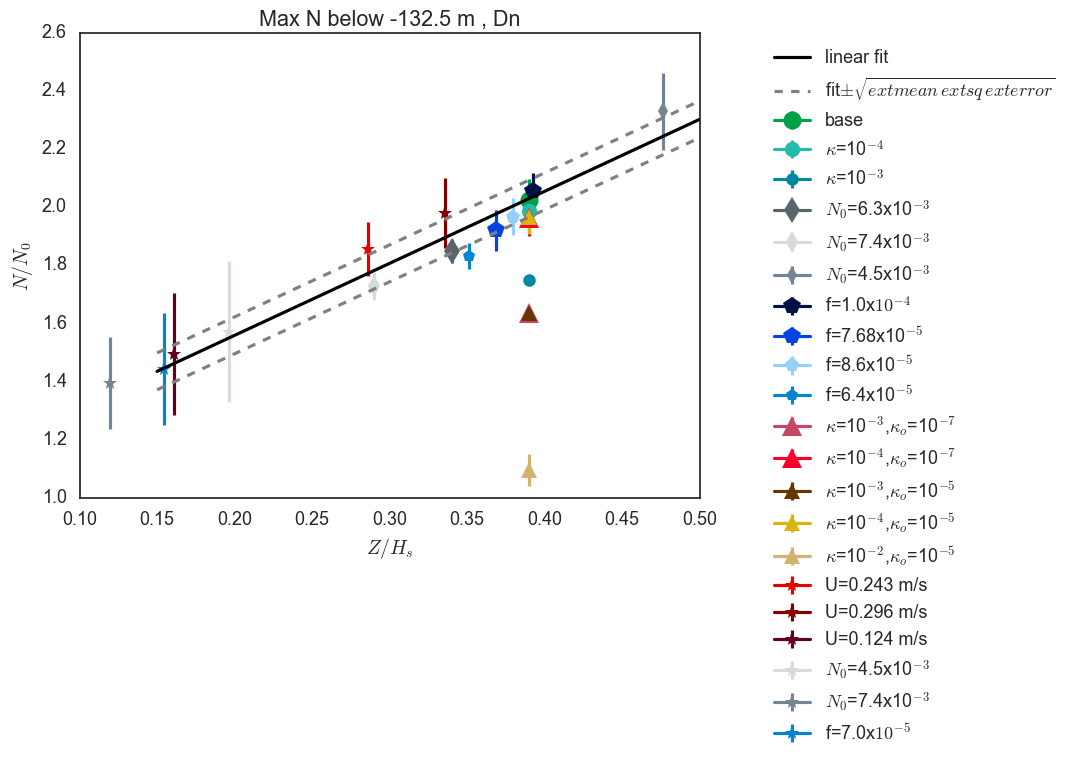

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.errorbar(((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/(Hs*rec.N),rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    ax.set_title('Max N below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$N/N_0$')
    ax.set_xlabel('$Z/H_s$')

    ax.legend(bbox_to_anchor=(1.6,1))
#ax.set_xscale('log')    


# Linear fit
records_NoKv = [records[0],records[3],records[4],records[5],records[6],records[7],records[8],records[9],records[15],
                records[16],records[17]]

maxN_array = np.array([rec.maxN/rec.N for rec in records_NoKv])
tilt_array = np.array([((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/(Hs*rec.N) for rec in records_NoKv])

x_fit = np.linspace(0.15, 0.5, 50)

plt3 = ax.plot(x_fit,slope*x_fit+intercept,'-k',label='linear fit')

mean_sq_err = np.mean((maxN_array-(slope*tilt_array+intercept))**2)

upper_bound = ax.plot(x_fit,slope*x_fit+intercept+(mean_sq_err)**(0.5),linestyle = '--',color='0.5', label = 'fit$\pm\sqrt{\text{mean}\,\text{sq}\,\text{error}}$')
lower_bound = ax.plot(x_fit,slope*x_fit+intercept-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
ax.legend(bbox_to_anchor=(1.6,1))
plt.show()



It kind of works...

### Now, let's add Kv

(It is evident from the plot above that the diffusivity we care about is the one within the canyon.)

Higher diffusivities trasnform this problem into a time dependet one. If the diffusivity is high enough that the timescale that diffusion acts on is on the order of the duration of our upwelling event, then the relationship we found above will fall short in its estimate of the stratification amplification within the canyon. This is becuase during the time-dependent phase of upwelling diffusivity kept (destroying) acting on the vertical density gradient. This may have consequenses when we calculate the depth of upwelling or the upwelling flux, since the effective or apparent initial stratification N_0 will be smaller. In particular, if stratification decreases the depth of upwelling, as well as the upwelling flux, increase.  

### Diffusion timescale
A timescale for diffusion is given by $\tau=(H_{\kappa})^2/\kappa_v$. 

Where $H_{\kappa}$ is an appropriate depth scale for diffusivity to act along. We care about the stratification within the canyon, on the dowstream side, so this scale could be $H_s-H_h$, the difference between shelf break depth and canyon head depth. This might not be right but since I'm not changing the bathymetry I can't really tell.

In our simulations, $\kappa_v$ goes from $10^{-3}$ to $10^{-5}$ m$^2$s$^{-1}$, so $\tau$ goes from 4.6 days to 462 days for $H_{\kappa}=20$ m.


Considering the base case (U=0.358 m/s, No=5.5$\times$10$^{-3}$s$^{-1}$,f=9.66$\times$10$^{-5}$s$^{-1}$,L=6400 m ) and a time dependent phase of 4 days, this means $\kappa_v > 0.0008$ $m^2/s$. This is a 

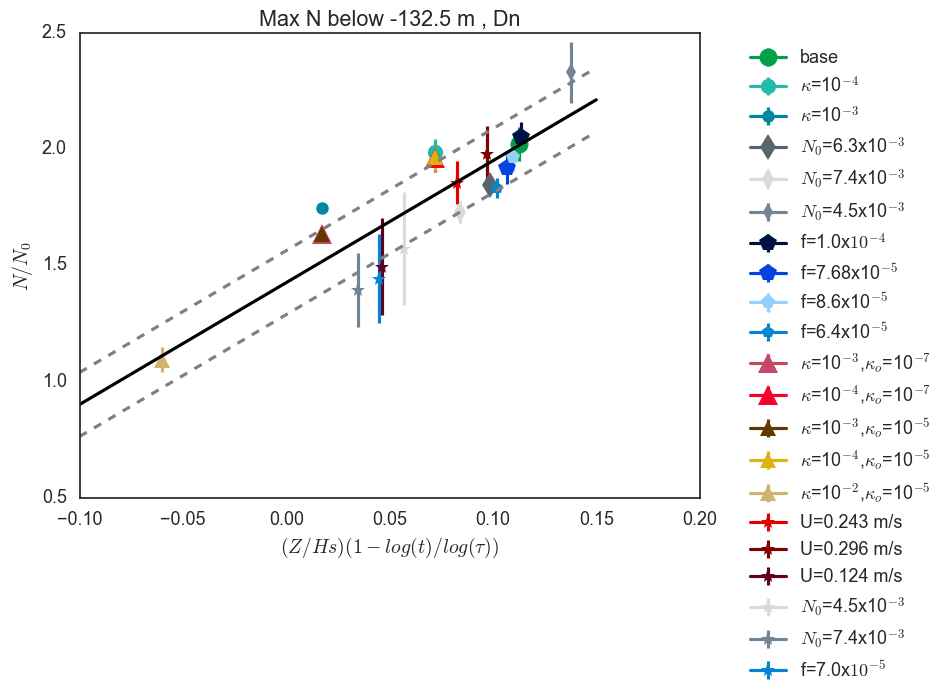

In [13]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax.errorbar((Z/Hs)*(TauNo),rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    rec.tauNo = TauNo 
    rec.Z = Z
    ax.set_title('Max N below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$N/N_0$')
    ax.set_xlabel(r'$(Z/Hs)(1-log(t)/log(\tau))$')

    ax.legend(bbox_to_anchor=(1.2,1))
#ax.set_xscale('log')    

# Linear fit

maxN_array_Kv = np.array([rec.maxN/rec.N for rec in records])
tilt_array_Kv = np.array([(rec.Z/Hs)*rec.tauNo for rec in records])

x_fit = np.linspace(-0.1, 0.15, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
ax.legend(bbox_to_anchor=(1.4,1))

plt.show()

Stratification within the canyon becomes a time dependent problem with enough diffusivity within the canyon. Enough diffusivity means that the relevant timescale for diffusion $\tau$ given by $Z^2/\kappa_v$ is on the order of the ramp up time to get to the steady incoming velocity $U$ or on the order of the duration of the upwelling event. If a storm takes too long to develop then mixing within the canyon can increase or decrease whatever estimate we would do using AH2010. Specifically, too much mixing will decrease the stratification within the canyon, which will increase the depth of upwelling... or something like that.

### When is diffusion relevant to N?

The condition under which diffusion will wipe out all stratification is 
$$t/ \tau \approx 0.7$$, because that is when the argument (1-0.7t/\tau) is zero.

This comes from trying to find the best fit for $(Z/H_s)(1-\beta t/\tau)$, however I did this based on what looked best.I need to fing a better mathy justification for this.

The condition above implies that the $\kappa_v$ required to homogeneize the water column in 4 days is  

$\kappa_v = \frac{1.43((H_s-H_h)/2)^2}{4 \, days} \approx \frac{1.4\times25^2}{(4\times3600\times24)} \approx 2.6 \times 10^{-3}$ m$^2$s$^{-1}$


In [14]:
print(slope_Kv,intercept_Kv)

5.24212803867 1.42570808724


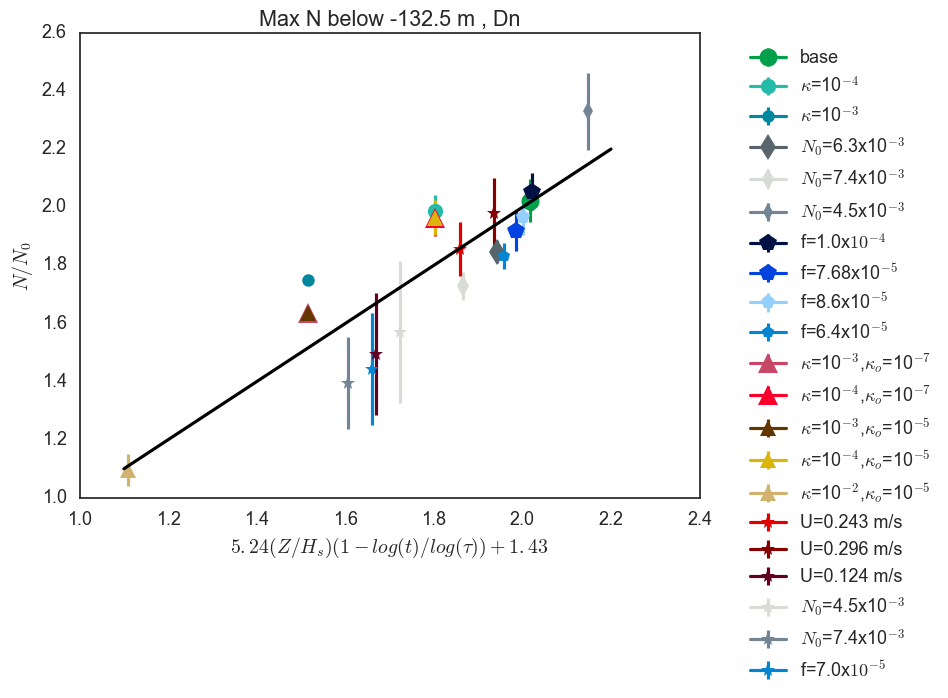

In [15]:

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax.errorbar((slope_Kv*(Z/Hs)*(TauNo))+intercept_Kv,rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    rec.tauNo = TauNo 
    rec.Z = Z
    ax.set_title('Max N below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$N/N_0$')
    ax.set_xlabel(r'$%1.2f(Z/H_s)(1-log(t)/log(\tau))+%1.2f$' %(slope_Kv,intercept_Kv))

    ax.legend(bbox_to_anchor=(1.2,1))
#ax.set_xscale('log')    
ax.plot(np.linspace(1.1,2.2,50),np.linspace(1.1,2.2,50),'k-')

ax.legend(bbox_to_anchor=(1.4,1))

plt.show()

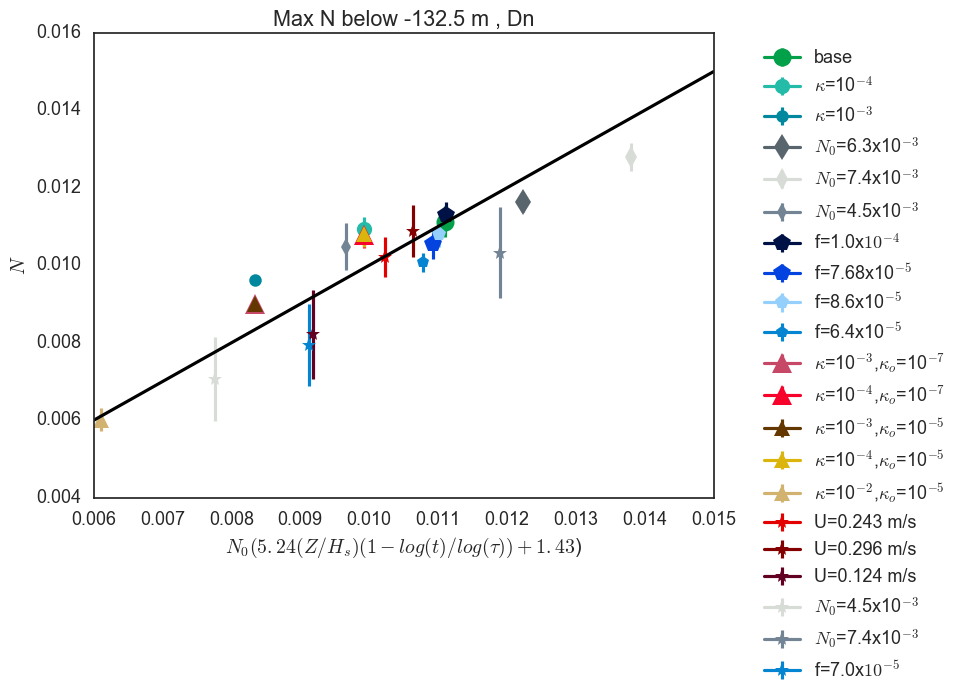

In [16]:

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax.errorbar(rec.N*((slope_Kv*(Z/Hs)*(TauNo))+intercept_Kv),rec.maxN,
                       yerr = rec.stdN, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    rec.tauNo = TauNo 
    rec.Z = Z
    ax.set_title('Max N below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$N$')
    ax.set_xlabel(r'$N_0(%1.2f(Z/H_s)(1-log(t)/log(\tau))+%1.2f$)' %(slope_Kv,intercept_Kv))

    ax.legend(bbox_to_anchor=(1.2,1))
#ax.set_xscale('log')    
ax.plot(np.linspace(0.006,0.015),np.linspace(0.006,0.015),'k-')

ax.legend(bbox_to_anchor=(1.4,1))

plt.show()